# Weather Project - Seattle vs Portland Precipitation

## Introduction

This project looks to determine whether there is more rainfall in the city of Portland or the city of Seattle on average. To accomplish this task, we've taken NOAA weather data for both cities across the time period of 2018-2022. Using this weather data, we will look at three different ways of determining which city has more rainfall: Daily Precipitation, Mean Monthly Precipitation, and Mean Monthly Proportion of Days with Precipitation. \
\
    1. Mean Daily Precipitation will look at the daily precipitation for both cities on a daily basis across the five year timespan. \
    2. Mean monthly precipitation takes the average of each month across the five years of data (i.e. January from 2018-2022). \
    3. Mean monthly proportion of days with precipitation looks at the average number of days with precipitation in each month, and then averages those months across the five years of data, in a similar way to the mean monthly precipitation data.

This code imports the necessary packages.

In [1]:
# Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# seaborn is a data visualization library built on matplotlib
import seaborn as sns

# set the plotting style
sns.set_style("whitegrid")

## Cleaning and Combining the Datasets

After importing the packages, we read in the csvs of the two datasets we want to compare. Then we set the date columns to the datetime type, so they can be appropriately organized.

In [2]:
df_seattle = pd.read_csv(
    'https://raw.githubusercontent.com/brian-fischer/DATA-5100/main/weather/seattle_rain.csv'
)
df_portland = pd.read_csv(
    'https://raw.githubusercontent.com/jamilditter/weather_jamil/2d7fb10ca279483f3ffc6f04d81689a39493079e/data/portland_rain.csv'
)

In [3]:
df_seattle['DATE'] = pd.to_datetime(df_seattle['DATE'])
df_portland['DATE'] = pd.to_datetime(df_portland['DATE'])

/tmp/ipykernel_14889/2580292922.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_seattle['DATE'] = pd.to_datetime(df_seattle['DATE'])


Here we merge the two datasets together, so we can directly compare their values. After merging the data, we reorganize the dataset so we can see the precipitation over time for the two cities. We rename the columns to follow standard naming practice.

In [4]:
df = df_portland[['DATE', 'PRCP']].merge(df_seattle[['DATE', 'PRCP']], on='DATE', how='outer')

In [5]:
df = pd.melt(df, id_vars='DATE', var_name='city', value_name='precipitation')

In [6]:
df.loc[df['city'] == 'PRCP_x', 'city'] = 'POR'
df.loc[df['city'] == 'PRCP_y', 'city'] = 'SEA'

In [7]:
df = df.rename(columns={'DATE': 'date'})

This dataset should now show the precipitation over time for the two cities, with each city being its own column, showing the precipitation for each day in the dataset.

Because there is missing data in the Seattle dataset, we are creating a new variable to track which day of the year it is, and creating an average for every day in a year, by taking the same day across the 5 years of data and averaging them together. We then use this new averaged day to fill in any missing days in the Seattle dataset.

In [8]:
df['day_of_year'] = pd.DatetimeIndex(df['date']).day_of_year

In [9]:
# Creates a daily average for Seattle representing the same day averaged out from the five years of data
mean_day_precipitation = df.loc[
    df['city'] == 'SEA',
    ['precipitation', 'day_of_year']
].groupby(
    'day_of_year'
).mean()

In [10]:
indices = np.where(df['precipitation'].isna() == True)[0]

In [11]:
# Replaces missing values with averaged values from years corresponding to that day
for index in indices:
    df.loc[index, 'precipitation'] = mean_day_precipitation.loc[df.loc[index,'day_of_year']].values[0]

## Exploratory Data Analysis

### Daily Precipitation

To answer the question of whether it rains more in Seattle or Portland, there are a number of different data points we can look at. To start, we're graphing the daily precipitation (in inches) by city over time.

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


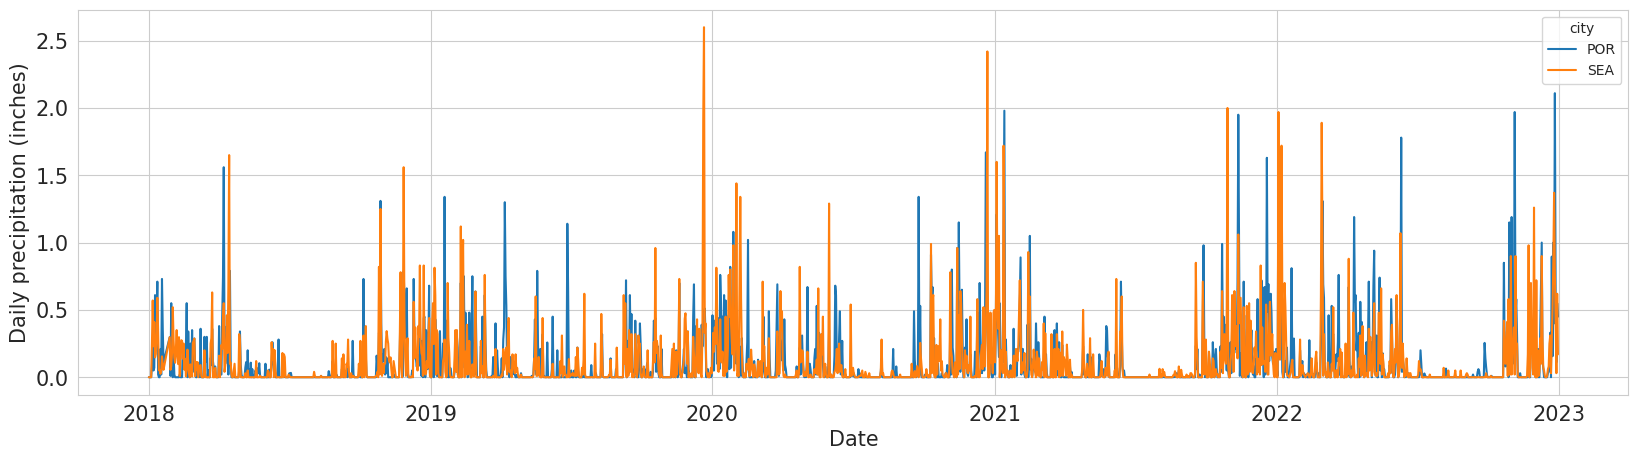

In [12]:
plt.figure(figsize=(20,5))

sns.lineplot(data=df, x='date', y='precipitation', hue='city')

plt.xlabel('Date', fontsize=15)
plt.ylabel('Daily precipitation (inches)', fontsize=15)

plt.tick_params(labelsize=15)

plt.show()

While it is nice to see all the information present in the dataset, it is hard to interpret exactly what this chart is showing us. The two cities seem to have fairly similar levels of precipitation, and it would be very hard to determine exactly which city had more precipitation from this chart alone. Below, we're going to look at the average precipitation across all 5 years, to get a more general idea of how much daily precipitation each city experiences.

Here, we're going to be doing a simple comparison of mean daily precipitation between both cities.

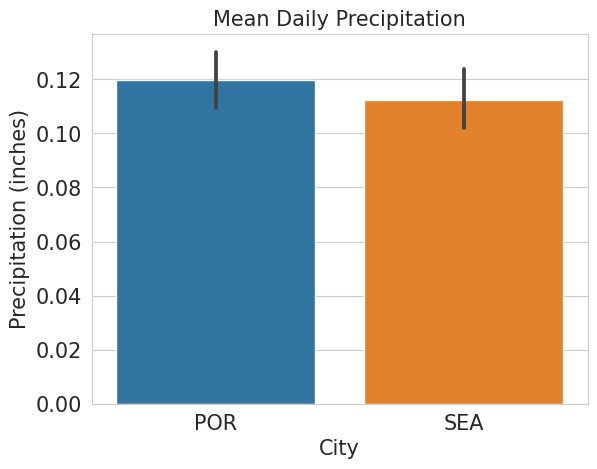

In [15]:
sns.barplot(data=df, x='city', y='precipitation')

plt.ylabel('Precipitation (inches)', fontsize=15)
plt.xlabel('City', fontsize=15)
plt.title('Mean Daily Precipitation', fontsize=15)

plt.tick_params(labelsize=15)

plt.show()

As this bar chart shows, the difference in mean daily precipitation between the two cities is very slight, with a difference of about 0.01 inches, and error bars that overlap. While it seems that Portland might have more daily rain, it is very close, and so we are going to look at a couple other ways to compare the two cities.

### Mean Monthly Precipitation

To do that, we create a month column, and use this to look at the monthly precipitation values for each city. 

In [16]:
df['month'] = pd.DatetimeIndex(df['date']).month
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

Here, we're importing scipy to perform a t-test, specifically looking to see if there if the difference between the monthly precipitation between cities is statistically significant or not (p-value of less than 0.05).

In [18]:
from scipy import stats

In [19]:
significance_level = 0.05
significantly_different = np.zeros(12)

# Perform t-test for each month
for month in range(1,13):
    # Get precipitation data for Seattle and Portland for the current month
    sea_data = df.loc[(df['city'] == 'SEA') & (df['month'] == month), 'precipitation']
    por_data = df.loc[(df['city'] == 'POR') & (df['month'] == month), 'precipitation']

    t_statistic, p_value = stats.ttest_ind(sea_data, por_data, equal_var=False)

    if p_value < significance_level:
        significantly_different[month-1] = 1

    print(f"Month {month}:")
    print(f" t-statistic = {t_statistic:.2f}")
    print(f" p-value t test = {p_value:.3f}")
    print("-" * 20)

Month 1:
 t-statistic = -0.15
 p-value t test = 0.880
--------------------
Month 2:
 t-statistic = 0.95
 p-value t test = 0.344
--------------------
Month 3:
 t-statistic = -1.37
 p-value t test = 0.173
--------------------
Month 4:
 t-statistic = -1.30
 p-value t test = 0.193
--------------------
Month 5:
 t-statistic = -1.42
 p-value t test = 0.156
--------------------
Month 6:
 t-statistic = -0.84
 p-value t test = 0.403
--------------------
Month 7:
 t-statistic = 1.36
 p-value t test = 0.176
--------------------
Month 8:
 t-statistic = 1.75
 p-value t test = 0.082
--------------------
Month 9:
 t-statistic = -0.81
 p-value t test = 0.417
--------------------
Month 10:
 t-statistic = 0.29
 p-value t test = 0.775
--------------------
Month 11:
 t-statistic = 0.05
 p-value t test = 0.960
--------------------
Month 12:
 t-statistic = -0.40
 p-value t test = 0.687
--------------------


The difference in mean monthly precipitation between Seattle and Portland is not statistically significant in any of the months, and thus it is hard to draw a conclusion from this comparison. We've added a caveat to the chart below, to add a star above the month if the difference between the mean monthly precipitation is statistically significant.

Here, we're making a bar chart looking at the mean precipitation for each city on a monthly basis, with a star above the months to represent months where the difference between the two cities is statistically significant.

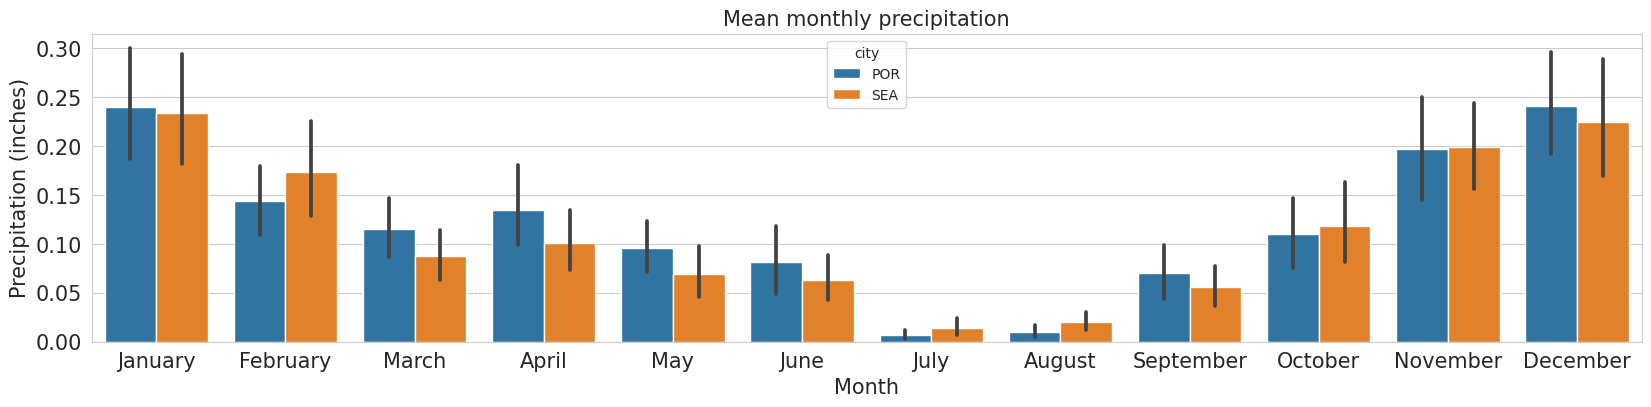

In [20]:
plt.figure(figsize=(20,4))

sns.barplot(data=df, x='month', y='precipitation', hue='city')

plt.xlabel('Month', fontsize=15)
plt.ylabel('Precipitation (inches)', fontsize=15)
plt.title('Mean monthly precipitation', fontsize=15)

plt.tick_params(labelsize=15)

plt.xticks(ticks=range(12), labels=month_names)

for month in range(12):
    if significantly_different[month] == 1:
        plt.text(month, 0.3, '*', ha='center', fontsize=25)

plt.show()

Seattle has a number of months with higher average precipitation than Portland, with 5 months being higher. While most of the first half of the year, Portland has a higher mean monthly precipitation, in the second half, this trend is reversed, with Seattle having a higher monthly mean precipitation for four out of six of those months.

However, none of the months were statistically significant, as we'd already seen from the list of p-value t tests above. This makes it hard to draw any conclusive conclusions from this, as while Portland may have higher mean monthly precipitation across more months, none of the differences between the mean monthly precipitations was statistically significant.

### Mean Monthly Proportion of Days with Precipitation

Here, we're going to create a new variable to look at only days where there was precipitation, and then use that variable to create a bar chart showing the proportion of days with precipitation per city.

In [21]:
df['any_precipitation'] = df['precipitation'] > 0

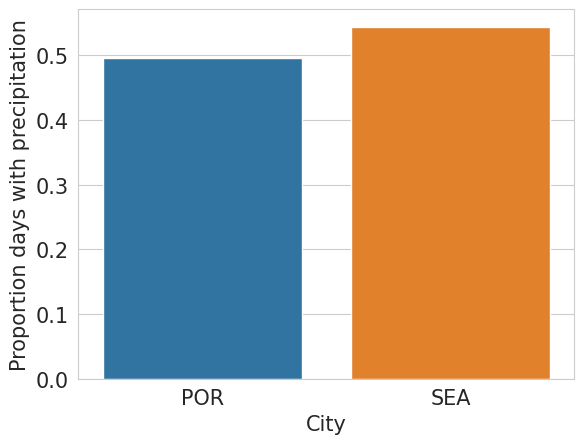

In [22]:
sns.barplot(data=df, x='city', y='any_precipitation', errorbar=None)

plt.xlabel('City', fontsize=15)
plt.ylabel('Proportion days with precipitation', fontsize=15)

plt.tick_params(labelsize=15)

plt.show()

This presents a different conclusion than the mean monthly precipitation seems to suggest. As we've shown above, on average, precipitation in Portland tends to be higher than that in Seattle. However, if we look purely at the number of days of precipitation in both cities, Seattle on average has more days of precipitation than Portland. 

Here, we're importing a z-statistic to run a z-test on our proportion of days with precipitation data. We use a contingency table to make a note of all the days in a month where there was precipitation in each of the cities, and use this to conduct a z-test to determine in which months there was a statistically significant difference in the number of days with precipitation between the two cities.

In [24]:
from statsmodels.stats.proportion import proportions_ztest

significance_level = 0.05
significantly_different_proportion = np.zeros(12)

# Perform t-test for each month
for month in range(1,13):
    
    # Create a contingency table for Seattle and Portland for the current month
    contingency_table = pd.crosstab(
        df.loc[df['month'] == month, 'city'], df.loc[df['month'] == month, 'any_precipitation']
    )

    # Calculate the number of True values (days with precipitation) for each city
    days_with_precipitation = contingency_table[True]

    total_counts = contingency_table.sum(axis=1)

    # Hypothesis test
    zstat, p_value = proportions_ztest(
        count=days_with_precipitation, nobs=total_counts, alternative='two-sided'
    )

    if p_value < significance_level:
        significantly_different_proportion[month-1] = 1

    print(f"Month {month}:")
    print(f" z-statistic = {zstat:.2f}")
    print(f" p-value = {p_value:.3f}")
    print("-" * 20)

Month 1:
 z-statistic = -0.27
 p-value = 0.788
--------------------
Month 2:
 z-statistic = -2.86
 p-value = 0.004
--------------------
Month 3:
 z-statistic = 1.14
 p-value = 0.254
--------------------
Month 4:
 z-statistic = -0.82
 p-value = 0.412
--------------------
Month 5:
 z-statistic = 2.05
 p-value = 0.041
--------------------
Month 6:
 z-statistic = -0.58
 p-value = 0.559
--------------------
Month 7:
 z-statistic = -2.49
 p-value = 0.013
--------------------
Month 8:
 z-statistic = -3.53
 p-value = 0.000
--------------------
Month 9:
 z-statistic = -0.12
 p-value = 0.905
--------------------
Month 10:
 z-statistic = -1.25
 p-value = 0.211
--------------------
Month 11:
 z-statistic = -1.86
 p-value = 0.063
--------------------
Month 12:
 z-statistic = -1.79
 p-value = 0.073
--------------------


We find that there are four months in which the difference between the number of days with precipitation was statistically significant (has a p-value of less than 0.05). These months are February, May, July, and August. In all but May, Seattle has a higher number of days with precipitation than Portland. This is more promising in showing that there is greater significance to arguing that Seattle had a higher number of days with precipitation, and that this difference was significant enough to confirm these results, at least in 3 of the 4 months that had statistically significant differences. 

Here, we're creating a bar chart showing the proportion of days with precipitation on a monthly basis for both cities, with a star above the months to represent months where the difference between the two cities is statistically significant.

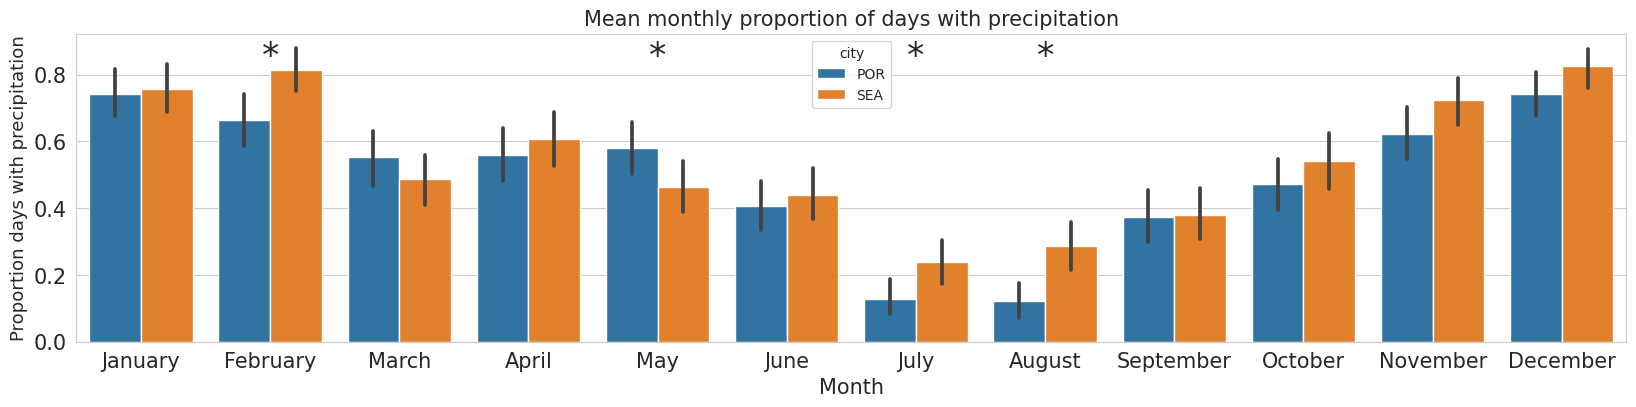

In [40]:
plt.figure(figsize=(20, 4))

sns.barplot(data=df, x='month', y='any_precipitation', hue='city')

plt.xlabel("Month", fontsize=15)
plt.ylabel('Proportion days with precipitation', fontsize=13)
plt.title('Mean monthly proportion of days with precipitation', fontsize=15)

plt.xticks(ticks=range(12), labels=month_names)
plt.tick_params(labelsize=15)

for month in range(12):
    if significantly_different_proportion[month] == 1:
        plt.text(month, 0.825, '*', ha='center', fontsize=25)

plt.show()

This allows us to see that in all but the months of March and May, Seattle has a higher proportion of days with precipitation than Portland does. If we consider the city with more days of precipitation to be the city with a higher proportion of days where there was precipitation, then with this chart we could argue that Seattle has more average rainfall than Portland does. 

## Conclusion

We looked at three different ways of determining which city had more rainfall in any given year. For both mean daily precipitation and mean monthly precipitation, Portland had slightly more rainfall, while when looking at the mean monthly proportion of days with precipitation, Seattle had a higher proportion, and had more months where precipitation occurred more frequently. I think because of how close the precipitation differences between the two cities are, it is fair to say that there is no significant difference between the two in terms of rainfall, or at the very least not enough of a significant difference to indicate one way or the other. In answer to the question, does Seattle or Portland have more rainfall, this report would conclude that there is no clear difference between the two, and that the rainfall both get is too similar to declare one to have outright more than the other.